<a href="https://colab.research.google.com/github/Arvinth-s/Dark-Sight/blob/master/MaskRCNN_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
#OM NAMO NARAYANA

In [16]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

In [17]:
#We use '!' for running shell command
#Implemented on the base of pytorch tutorial
#https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
if ('PennFudanPed.zip' not in os.listdir('/content/')):
  !wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
else:
  print('Already downloaded')


Already downloaded


In [18]:
if("PennFudanPed" not in os.listdir('/content/')):
  !unzip 'PennFudanPed.zip'
else:
  print('Already unzipped')

Already unzipped


In [19]:
os.chdir('/content/PennFudanPed')
os.listdir('./')

['Annotation', 'PNGImages', 'readme.txt', 'PedMasks', 'added-object-list.txt']

In [20]:
#__setitem__ and __getitem__
#https://stackoverflow.com/questions/43627405/understanding-getitem-method#:~:text=The%20magic%20method%20__getitem,'%20(date%20of%20birth).

class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        # img.show()
        # plt.imshow(img)
        # print(img)
        # print('showing image')
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)
        # print('my target', target)
        return (img, target)

    def __len__(self):
        return len(self.imgs)

In [21]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [22]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator


backbone = torchvision.models.mobilenet_v2(pretrained=True).features

backbone.out_channels = 1280


anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))


roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [23]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):

    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)


    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [24]:
import torchvision.transforms as T

def get_transform(train):
    print(type(train))
    transforms = []
    transforms.append(T.ToTensor())
    # if train:
    #     transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [25]:
def my_collate(batch):
  return ([cbatch[0] for cbatch in batch], [cbatch[1] for cbatch in batch])

In [26]:
import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset('/content/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=1, shuffle=True, num_workers=4,
 collate_fn=my_collate)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
print('images', images)
targets = [{k: v for k, v in t.items()} for t in targets]
print('target', targets)

output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

<class 'bool'>
images [tensor([[[0.2000, 0.2000, 0.1882,  ..., 0.3255, 0.2941, 0.2588],
         [0.1922, 0.1922, 0.1843,  ..., 0.5294, 0.5176, 0.5020],
         [0.1922, 0.1961, 0.1922,  ..., 0.3647, 0.3843, 0.4039],
         ...,
         [0.4627, 0.4667, 0.4706,  ..., 0.6039, 0.5961, 0.5961],
         [0.4588, 0.4706, 0.4784,  ..., 0.6078, 0.6000, 0.6000],
         [0.4588, 0.4784, 0.4863,  ..., 0.6078, 0.6039, 0.6039]],

        [[0.2745, 0.2745, 0.2745,  ..., 0.3333, 0.3020, 0.2667],
         [0.2667, 0.2667, 0.2706,  ..., 0.5373, 0.5255, 0.5098],
         [0.2706, 0.2745, 0.2784,  ..., 0.3725, 0.3922, 0.4118],
         ...,
         [0.4863, 0.4902, 0.4941,  ..., 0.6118, 0.6039, 0.6039],
         [0.4824, 0.4941, 0.5020,  ..., 0.6157, 0.6078, 0.6078],
         [0.4824, 0.5020, 0.5098,  ..., 0.6157, 0.6118, 0.6118]],

        [[0.3294, 0.3294, 0.3255,  ..., 0.3137, 0.2824, 0.2471],
         [0.3216, 0.3216, 0.3216,  ..., 0.5176, 0.5059, 0.4902],
         [0.3137, 0.3176, 0.3294,  

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [252]:
import matplotlib.pyplot as plt
import numpy
from time import sleep

class myDplot():
  def __init__(self, n_r, n_c):
    self.n_r = n_r
    self.n_c = n_c
    self.figure, self.h = plt.subplots(n_r, n_c)
    self.count = 0
    self.xdata = []
    self.ydata = []
    # plt.show()

  def update_line(self, new_data):
      # print(new_data)
      plt.cla()
      self.figure, self.h = plt.subplots(self.n_r, self.n_c)
      if(type(len(new_data)) != list and len(new_data) == self.n_r * self.n_c):
        new_data = list(np.array(new_data).reshape(self.n_r, self.n_c))
      if(len(new_data) != self.n_r or len(new_data[0]) != self.n_c):
        print('dimension mismatch')
        return
      print(np.array(h).shape)
      self.xdata.append(np.ones((self.n_r, self.n_c))*self.count)
      self.ydata.append(new_data)
      # self.xdata = [np.ones((self.n_r, self.n_c))*self.count]
      # self.ydata = [new_data]
      print(self.xdata, self.ydata)
      for i in range(self.n_r):
        for j in range(self.n_c):
          # self.xdata.append(self.count)
          # self.ydata.append(new_data[i][j])
          self.h[i][j].clear()
          print('self', self.xdata[self.count][i][j], self.ydata[self.count][i][j])
          self.h[i][j].plot([self.xdata[x][i][j] for x in range(self.count+1)], [self.ydata[y][i][j] for y in range(self.count+1)])
          # self.h[i][j].clear()
      self.count = self.count+1
      # self.figure.canvas.draw()
      # self.figure.canvas.flush_events()
      # plt.draw()
      plt.show()

      # plt.draw()

(5,)
[array([[0., 0., 0.],
       [0., 0., 0.]])] [[array([0.92528623, 0.12338764, 3.68623161]), array([0.00853687, 0.00077487, 0.        ])]]
self 0.0 0.9252862334251404
self 0.0 0.1233876422047615
self 0.0 3.6862316131591797
self 0.0 0.008536873385310173
self 0.0 0.000774867890868336
self 0.0 0.0


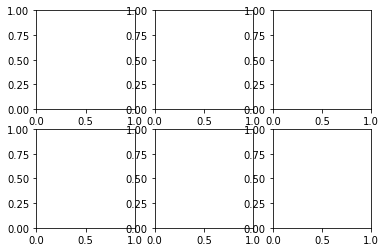

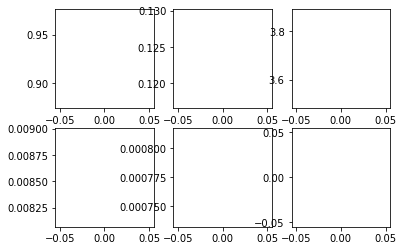

(5,)
[array([[0., 0., 0.],
       [0., 0., 0.]]), array([[1., 1., 1.],
       [1., 1., 1.]])] [[array([0.92528623, 0.12338764, 3.68623161]), array([0.00853687, 0.00077487, 0.        ])], [array([0.92528623, 0.12338764, 3.68623161]), array([0.00853687, 0.00077487, 0.        ])]]
self 1.0 0.9252862334251404
self 1.0 0.1233876422047615
self 1.0 3.6862316131591797
self 1.0 0.008536873385310173
self 1.0 0.000774867890868336
self 1.0 0.0


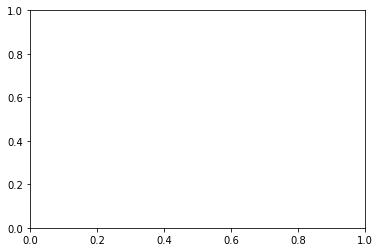

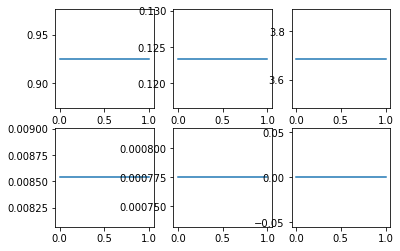

(5,)
[array([[0., 0., 0.],
       [0., 0., 0.]]), array([[1., 1., 1.],
       [1., 1., 1.]]), array([[2., 2., 2.],
       [2., 2., 2.]])] [[array([0.92528623, 0.12338764, 3.68623161]), array([0.00853687, 0.00077487, 0.        ])], [array([0.92528623, 0.12338764, 3.68623161]), array([0.00853687, 0.00077487, 0.        ])], [array([0.92528623, 0.12338764, 3.68623161]), array([0.00853687, 0.00077487, 0.        ])]]
self 2.0 0.9252862334251404
self 2.0 0.1233876422047615
self 2.0 3.6862316131591797
self 2.0 0.008536873385310173
self 2.0 0.000774867890868336
self 2.0 0.0


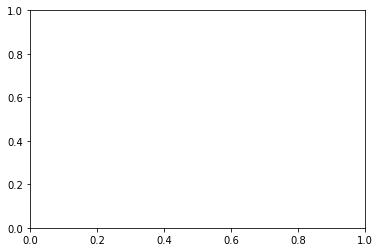

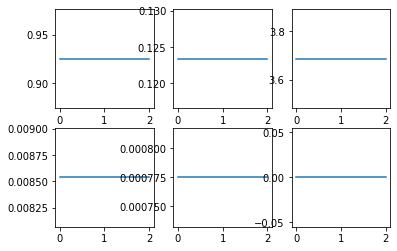

In [253]:
templot = myDplot(2, 3)
templot.update_line([0.9252862334251404, 0.1233876422047615, 3.6862316131591797, 0.008536873385310173, 0.000774867890868336, 0])
sleep(5)
templot.update_line([0.9252862334251404, 0.1233876422047615, 3.6862316131591797, 0.008536873385310173, 0.000774867890868336, 0])
sleep(5)
templot.update_line([0.9252862334251404, 0.1233876422047615, 3.6862316131591797, 0.008536873385310173, 0.000774867890868336, 0])
sleep(10)

In [215]:
def train_model(model, optimizer, scheduler, dataloader, num_epochs):
  dplot = myDplot(3, 2);
  for epoch in range(num_epochs):
    for phase in ['train', 'eval']:
      if(phase == 'train'):
        model.train()
      else:
        model.eval()
      running_loss = 0.0
      runnin_corrects = 0

      for inputs, labels in iter(data_loader):
        # inputs = inputs.to(device)
        # labels = labels.to(device)

        optimizer.zero_grad()
        # running_loss = 0

        with torch.set_grad_enabled(phase=='train'):
          # outputs=model(inputs)
          # _, preds = torch.max(outputs, 1)
          loss = model(inputs, labels)
          running_loss = []
          if(phase == 'train'):
            for item in loss:
              print(loss[item])
              # running_loss = loss[item].numpy()
              running_loss.append(loss[item].item())
              print(running_loss)
              loss[item].backward(retain_graph=True)
            optimizer.step()
            # scheduler.step()
          running_loss.append(0)
          dplot.update_line(running_loss)
          # running_loss += loss.item() * input.size(0)
          
          # running_corrects += torch.sum(preds==labels.data)
      if(phase=='train'):
        scheduler.step()
      # epoch_loss = running_loss / dataset_sizes[phase]
      # epoch_acc = running_corrects.double() / dataset_sizes[phase]

      # print('{} Loss: {:.4f} Acc: {:.4f}'.format(
          # phase, epoch_loss, epoch_acc
      # ))
      return model

<class 'bool'>
<class 'bool'>


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


tensor(0.6830, grad_fn=<NllLossBackward>)
[0.6829817891120911]
tensor(0.2404, grad_fn=<DivBackward0>)
[0.6829817891120911, 0.24040639400482178]
tensor(4.4283, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
[0.6829817891120911, 0.24040639400482178, 4.428308486938477]
tensor(0.0250, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
[0.6829817891120911, 0.24040639400482178, 4.428308486938477, 0.0250244103372097]
tensor(0.0038, grad_fn=<DivBackward0>)
[0.6829817891120911, 0.24040639400482178, 4.428308486938477, 0.0250244103372097, 0.003835335373878479]
(5,)
[array([[0., 0.],
       [0., 0.],
       [0., 0.]])] [[array([0.68298179, 0.24040639]), array([4.42830849, 0.02502441]), array([0.00383534, 0.        ])]]
self 0.0 0.6829817891120911
self 0.0 0.24040639400482178
self 0.0 4.428308486938477
self 0.0 0.0250244103372097
self 0.0 0.003835335373878479
self 0.0 0.0


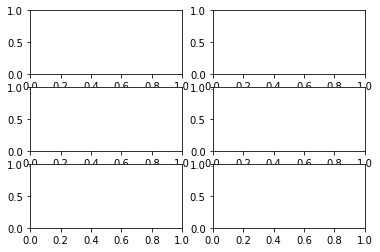

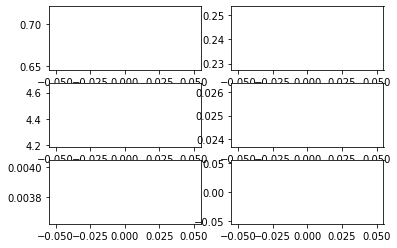

tensor(0.3201, grad_fn=<NllLossBackward>)
[0.32006189227104187]
tensor(0.3409, grad_fn=<DivBackward0>)
[0.32006189227104187, 0.3409154713153839]
tensor(1.7733, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
[0.32006189227104187, 0.3409154713153839, 1.773283839225769]
tensor(0.0338, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
[0.32006189227104187, 0.3409154713153839, 1.773283839225769, 0.033820658922195435]


In [ ]:
def main():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    num_classes = 2
    dataset = PennFudanDataset('/content/PennFudanPed', get_transform(train=True))
    dataset_test = PennFudanDataset('/content/PennFudanPed', get_transform(train=False))

    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,)
        # collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,)
        # collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_instance_segmentation(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # # train for one epoch, printing every 10 iterations
        # train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # # model.()
        # # update the learning rate
        # lr_scheduler.step()
        # # evaluate on the test dataset
        # evaluate(model, data_loader_test, device=device)
        # # model.eval()
        train_model(model, optimizer, lr_scheduler, data_loader, 10)
        model = model.train()

    print("That's it!")
main()

In [ ]:
# ! echo $PYTHONPATH

# import os
# print(os.environ['PYTHONPATH'])
# os.environ['PYTHONPATH'] += ":/content/gdrive/My Drive/Colab Notebooks/MaskRCNN_tutorial/src"
# print(os.environ['PYTHONPATH'])

In [ ]:
# !pip install utils

In [31]:
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)
print(predictions)

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward>)}, {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward>)}]


In [ ]:
print(output)

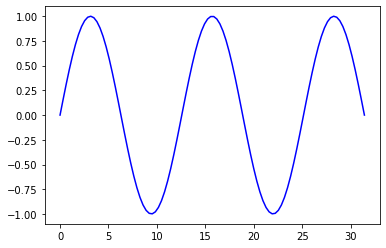

KeyboardInterrupt: ignored

In [245]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 10*np.pi, 100)
y = np.sin(x)

plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
line1, = ax.plot(x, y, 'b-')

for phase in np.linspace(0, 10*np.pi, 100):
  line1.set_ydata(np.sin(0.5 * x + phase))
  sleep(4)
  plt.show()